# Combine kernels

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import matplotlib.pyplot as plt
import pickle

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')

In [13]:
with open(f'{Path}/dpt.pkl', 'rb') as handle:
    dpt = pickle.load(handle)
with open(f'{Path}/veloVI.pkl', 'rb') as handle:
    velo = pickle.load(handle)
with open(f'{Path}/scvelo.pkl', 'rb') as handle:
    scvelo = pickle.load(handle)
with open(f'{Path}/cyto.pkl', 'rb') as handle:
    cyto = pickle.load(handle)

In [37]:
def load_data(key):
    with open(f'{Path}/{key}.pkl', 'rb') as handle:
        data = pickle.load(handle)
    return(data)

In [38]:
dpt=load_data('dpt')
velo=load_data('veloVI')
scvelo=load_data('scvelo')
cyto=load_data('cyto')

In [29]:
weights=[1,1,1,1]

In [30]:
weights=[1,1,1,1]
comb=weights[0]*dpt+weights[1]*velo+weights[2]*scvelo+cyto*weights[3]
comb=comb/np.sum(weights)
ck=cr.kernels.PrecomputedKernel(comb, adata=adata)

In [31]:
ck=cr.kernels.PrecomputedKernel(comb, adata=adata)

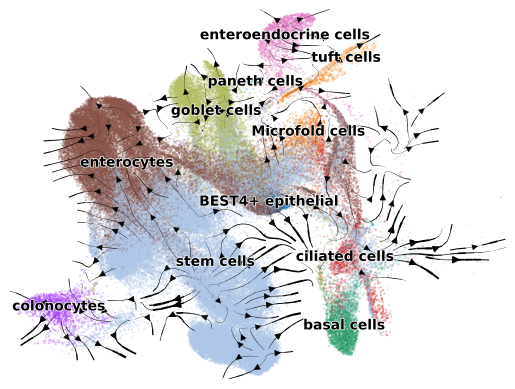

In [32]:
# This is the stream plot for only moscot+dpt (both weighted *0.5)
ck.plot_projection(basis='X_umap_sc', color="level_2", recompute=True, 
                   connectivities=adata.obsp['connectivities'], title='')

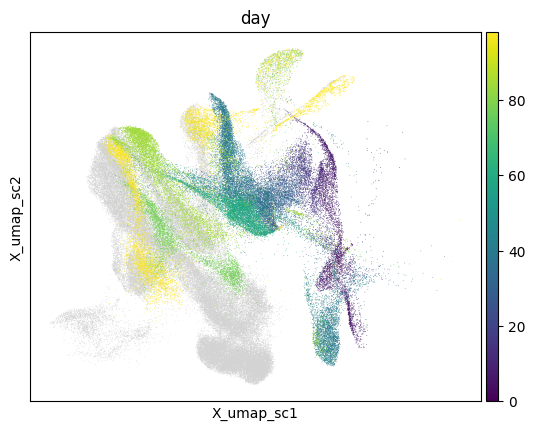

In [36]:
sc.pl.embedding(adata, basis='X_umap_sc', color='day')

## Estimate terminal states

In [8]:
g = cr.estimators.GPCCA(ck)


In [ ]:
# Without Krylov it fill instantiate a full (n_cells)x(n_cells) matrix, which will/might break RAM
T=g.compute_schur(n_components=20, method="krylov")

In [ ]:
g.compute_macrostates(n_states=20, cluster_key="level_2")

In [ ]:
g.predict_terminal_states(method="top_n", n_states=10)

In [ ]:
g.write(f'{Path}/gpcca.pkl')

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import matplotlib.pyplot as plt
import pickle

In [7]:
Path='/home/mgander/pancreas_multiome/data2'
g=cr.estimators.GPCCA.read(f'{Path}/gpcca.pkl')
adata=g.adata

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


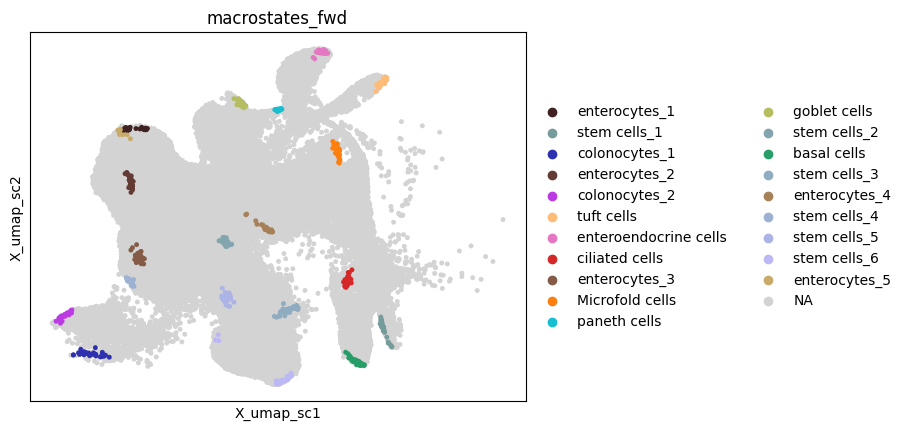

In [34]:
sc.pl.embedding(adata, basis='X_umap_sc', color='macrostates_fwd', size=50)

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


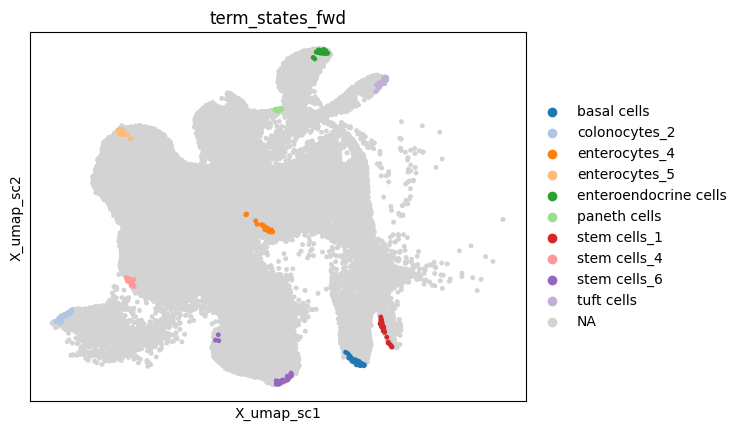

In [30]:
# For plotting all of them
#adata.obs['term_states_fwd']=[str(a) for a in adata.obs['term_states_fwd']]

pal=sns.color_palette('tab20').copy()
pal.append([0.8,0.8,0.8])
pall=pal[:len(set(list(adata.obs['term_states_fwd'])))]
pall[-1]=np.array([0.8,0.8,0.8])

sc.pl.embedding(adata, basis='X_umap_sc', color='term_states_fwd', size=50)

In [22]:
wh=np.where(adata.obs['term_states_fwd']=='nan')[0]

In [23]:
adata.obs['term_states_fwd'][wh]=np.NaN

In [28]:
adata.obs['term_states_fwd']=list(adata.obs['term_states_fwd'])

In [29]:
adata.obs['term_states_fwd'].astype('category').cat.categories

Index(['basal cells', 'colonocytes_2', 'enterocytes_4', 'enterocytes_5',
       'enteroendocrine cells', 'paneth cells', 'stem cells_1', 'stem cells_4',
       'stem cells_6', 'tuft cells'],
      dtype='object')

# Creating plots

In [21]:
fwd=adata.obs['term_states_fwd'].copy()

In [45]:
g.set_terminal_states({"Alpha": adata[fwd=='Alpha_1'].obs_names,
                    "Beta": adata[fwd=='Beta_1'].obs_names,
                    "Delta": adata[fwd=='Delta'].obs_names,
                    "Epsilon": adata[fwd=='Epsilon_2'].obs_names,
                       
                    #"Ngn3 high": adata[adata.obs['celltype']=='Ngn3 high'].obs_names,
                    #"Fev+ Delta": adata[adata.obs['celltype']=='Fev+ Delta'].obs_names,
                    #"Fev+ Beta": adata[adata.obs['celltype']=='Fev+ Beta'].obs_names,
                    #"Fev+ Alpha": adata[adata.obs['celltype']=='Fev+ Alpha'].obs_names,
                    #"Fev+": adata[adata.obs['celltype']=='Fev+'].obs_names
                    #"Eps/Delta progenitors": adata[adata.obs['celltype']=='Eps/Delta progenitors'].obs_names
                      })

GPCCA[kernel=PrecomputedKernel[n=9179], initial_states=['Ngn3 low_1', 'Ngn3 low_2'], terminal_states=['Alpha', 'Beta', 'Delta', 'Epsilon']]

In [ ]:
g.set_initial_states(['Ngn3 low_1', 'Ngn3 low_2'])

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


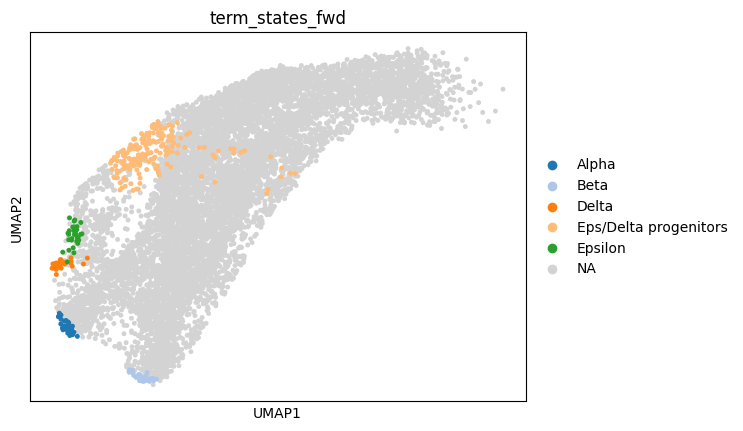

In [40]:
sc.pl.embedding(adata, basis='UMAP', color='term_states_fwd', palette=pall, size=50)

In [ ]:
with open(f'{Path}/list.pkl', 'wb') as f:
    pickle.dump(l, f)

In [49]:
with open(f'{Path}/list.pkl', 'rb') as f:
    l = pickle.load(f)

In [66]:
Df=pd.DataFrame(data=np.vstack(l), columns=['colonocytes_2', 'enterocytes_4', 'stem cells_4', 'paneth cells',
       'stem cells_1', 'stem cells_6', 'tuft cells', 'enterocytes_5',
       'enteroendocrine cells', 'basal cells'],
               index=adata.obs.index)

In [67]:
Df

colonocytes_2  enterocytes_4  stem cells_4  \
cells                                                              
AAACCCAAGGATCATA-7         0.087665       0.206149      0.157355   
AAACCCAGTAAGGCTG-7         0.094649       0.195655      0.171904   
AAACGAAGTCTACAAC-7         0.088008       0.205310      0.158255   
AAACGCTAGTTGCCCG-7         0.090393       0.201246      0.166767   
AAACGCTGTCGAACGA-7         0.100475       0.184042      0.192591   
...                             ...            ...           ...   
TTTGGTTTCGCCGATG-104       0.261306       0.154920      0.159360   
TTTGGTTTCTGAATGC-104       0.118936       0.171666      0.227323   
TTTGTTGAGGTCTTTG-104       0.086816       0.204334      0.156535   
TTTGTTGCAAGAGGCT-104       0.116405       0.169842      0.238874   
TTTGTTGTCTCAGTCC-104       0.089474       0.200398      0.166391   

                      paneth cells  stem cells_1  stem cells_6  tuft cells  \
cells                                                                        
AAACCCAAGGATCATA-7        0.019114      0.046695      0.011396    0.310580   
AAACCCAGTAAGGCTG-7        0.025331      0.056581      0.012116    0.247949   
AAACGAAGTCTACAAC-7        0.019111      0.046783      0.011452    0.309527   
AAACGCTAGTTGCCCG-7        0.019314      0.047256      0.011855    0.300609   
AAACGCTGTCGAACGA-7        0.026949      0.054865      0.013110    0.236132   
...                            ...           ...           ...         ...   
TTTGGTTTCGCCGATG-104      0.015999      0.038203      0.009956    0.227340   
TTTGGTTTCTGAATGC-104      0.020360      0.046892      0.013666    0.240011   
TTTGTTGAGGTCTTTG-104      0.018957      0.046635      0.011237    0.307021   
TTTGTTGCAAGAGGCT-104      0.019605      0.046311      0.014198    0.236403   
TTTGTTGTCTCAGTCC-104      0.019090      0.046693      0.011571    0.301723   

                      enterocytes_5  enteroendocrine cells  basal cells  
cells                                                                    
AAACCCAAGGATCATA-7         0.015756               0.041625     0.103674  
AAACCCAGTAAGGCTG-7         0.012300               0.045666     0.137857  
AAACGAAGTCTACAAC-7         0.016037               0.041749     0.103775  
AAACGCTAGTTGCCCG-7         0.015519               0.041971     0.105078  
AAACGCTGTCGAACGA-7         0.011790               0.046429     0.133623  
...                             ...                    ...          ...  
TTTGGTTTCGCCGATG-104       0.012603               0.034554     0.085765  
TTTGGTTTCTGAATGC-104       0.011975               0.042317     0.106861  
TTTGTTGAGGTCTTTG-104       0.023350               0.042239     0.102883  
TTTGTTGCAAGAGGCT-104       0.011865               0.041364     0.105139  
TTTGTTGTCTCAGTCC-104       0.018910               0.042354     0.103403  

[118336 rows x 10 columns]

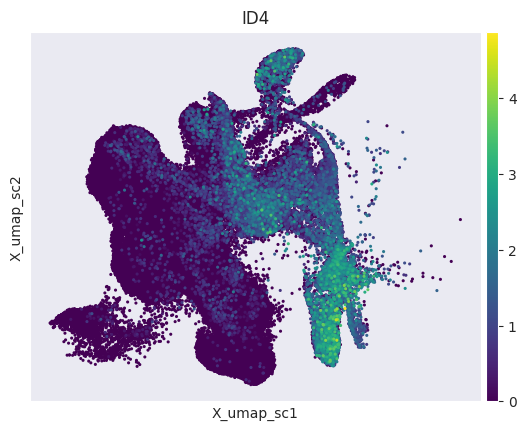

In [36]:
sc.pl.embedding(adata, basis='X_umap_sc', color='ID4', size=20, cmap='viridis')

In [68]:
adata.obs['basal_cells_absorption_probablity']=Df['basal cells']

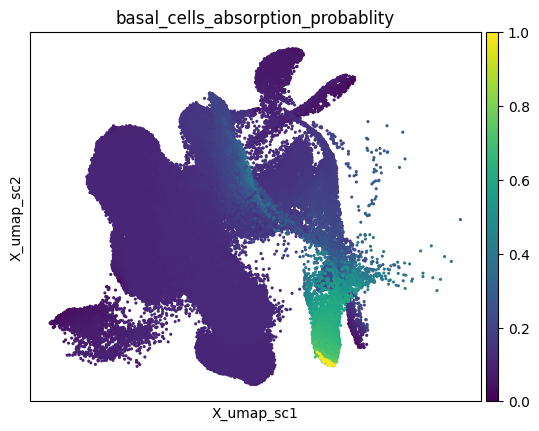

In [70]:
sc.pl.embedding(adata, basis='X_umap_sc', color='basal_cells_absorption_probablity', size=20)

In [14]:
df=pd.read_pickle(f'{Path}/driver_genes.pkl')

In [15]:
df

colonocytes_2_corr  colonocytes_2_pval  colonocytes_2_qval  \
COL5A3               0.412853                 0.0                 0.0   
SLC26A3              0.359725                 0.0                 0.0   
CEACAM7              0.357703                 0.0                 0.0   
CEACAM5              0.312263                 0.0                 0.0   
EMP1                 0.299628                 0.0                 0.0   
...                       ...                 ...                 ...   
OR13G1                    NaN                 NaN                 NaN   
DBX1                      NaN                 NaN                 NaN   
LINC01317                 NaN                 NaN                 NaN   
FAM170B                   NaN                 NaN                 NaN   
LCE5A                     NaN                 NaN                 NaN   

           colonocytes_2_ci_low  colonocytes_2_ci_high  enterocytes_4_corr  \
COL5A3                 0.408115               0.417568           -0.058772   
SLC26A3                0.354755               0.364675            0.014922   
CEACAM7                0.352724               0.362661            0.285395   
CEACAM5                0.307112               0.317396            0.254403   
EMP1                   0.294433               0.304805            0.177794   
...                         ...                    ...                 ...   
OR13G1                      NaN                    NaN                 NaN   
DBX1                        NaN                    NaN                 NaN   
LINC01317                   NaN                    NaN                 NaN   
FAM170B                     NaN                    NaN                 NaN   
LCE5A                       NaN                    NaN                 NaN   

           enterocytes_4_pval  enterocytes_4_qval  enterocytes_4_ci_low  \
COL5A3           4.282978e-91        1.146712e-90             -0.064448   
SLC26A3          2.841814e-07        4.388022e-07              0.009226   
CEACAM7          0.000000e+00        0.000000e+00              0.280153   
CEACAM5          0.000000e+00        0.000000e+00              0.249066   
EMP1             0.000000e+00        0.000000e+00              0.172271   
...                       ...                 ...                   ...   
OR13G1                    NaN                 NaN                   NaN   
DBX1                      NaN                 NaN                   NaN   
LINC01317                 NaN                 NaN                   NaN   
FAM170B                   NaN                 NaN                   NaN   
LCE5A                     NaN                 NaN                   NaN   

           enterocytes_4_ci_high  ...  enteroendocrine cells_corr  \
COL5A3                 -0.053093  ...                   -0.026518   
SLC26A3                 0.020618  ...                   -0.050805   
CEACAM7                 0.290620  ...                   -0.052543   
CEACAM5                 0.259724  ...                   -0.055072   
EMP1                    0.183306  ...                   -0.092066   
...                          ...  ...                         ...   
OR13G1                       NaN  ...                         NaN   
DBX1                         NaN  ...                         NaN   
LINC01317                    NaN  ...                         NaN   
FAM170B                      NaN  ...                         NaN   
LCE5A                        NaN  ...                         NaN   

           enteroendocrine cells_pval  enteroendocrine cells_qval  \
COL5A3                   7.227003e-20                1.839314e-19   
SLC26A3                  1.650740e-68                7.190166e-68   
CEACAM7                  3.730196e-73                1.674763e-72   
CEACAM5                  3.406740e-80                1.616586e-79   
EMP1                    2.280393e-221               1.865873e-220   
...                               ...                

In [ ]:
g.compute_fate_probabilities()

In [47]:
g.compute_lineage_drivers()

Alpha_corr     Alpha_pval     Alpha_qval  Alpha_ci_low  Alpha_ci_high  \
Gcg       0.670284   0.000000e+00   0.000000e+00      0.658861       0.681398   
Pou6f2    0.543937   0.000000e+00   0.000000e+00      0.529369       0.558183   
Gria2     0.516642   0.000000e+00   0.000000e+00      0.501484       0.531482   
Irx1      0.513621   0.000000e+00   0.000000e+00      0.498401       0.528526   
Irx2      0.499676   0.000000e+00   0.000000e+00      0.484167       0.514870   
...            ...            ...            ...           ...            ...   
Nnat     -0.252614  4.654368e-135  1.066287e-132     -0.271668      -0.233362   
Sytl4    -0.254528  3.556740e-137  8.277607e-135     -0.273561      -0.235295   
Pclo     -0.279371  2.183262e-166  6.810850e-164     -0.298125      -0.260401   
Pard3    -0.301801  1.218244e-195  4.827537e-193     -0.320281      -0.283091   
Amy2a1         NaN            NaN            NaN           NaN            NaN   

        Beta_corr      Beta_pval      Beta_qval  Beta_ci_low  Beta_ci_high  \
Gcg     -0.350766  9.560726e-270  7.377862e-267    -0.368579     -0.332696   
Pou6f2  -0.355147  4.163840e-277  3.591189e-274    -0.372896     -0.337139   
Gria2   -0.407781   0.000000e+00   0.000000e+00    -0.424696     -0.390581   
Irx1    -0.373467  2.802999e-309  3.161351e-306    -0.390938     -0.355727   
Irx2    -0.429620   0.000000e+00   0.000000e+00    -0.446157     -0.412790   
...           ...            ...            ...          ...           ...   
Nnat     0.361305  1.141313e-287  1.045871e-284     0.343386      0.378962   
Sytl4    0.383836   0.000000e+00   0.000000e+00     0.366254      0.401143   
Pclo     0.197690   4.518844e-82   4.944425e-80     0.177952      0.217269   
Pard3    0.103743   1.989336e-23   5.524175e-22     0.083462      0.123938   
Amy2a1        NaN            NaN            NaN          NaN           NaN   

        Delta_corr    Delta_pval    Delta_qval  Delta_ci_low  Delta_ci_high  \
Gcg      -0.082875  1.763100e-15  1.859754e-13     -0.103158      -0.062523   
Pou6f2   -0.079601  2.151393e-14  2.061681e-12     -0.099896      -0.059239   
Gria2     0.061692  3.276276e-09  1.854701e-07      0.041287       0.082047   
Irx1     -0.092370  7.084463e-19  1.038724e-16     -0.112615      -0.072048   
Irx2     -0.094361  1.235774e-19  1.948271e-17     -0.114597      -0.074046   
...            ...           ...           ...           ...            ...   
Nnat     -0.076503  2.093158e-13  1.805288e-11     -0.096810      -0.056133   
Sytl4    -0.131154  1.332813e-36  4.766269e-34     -0.151206      -0.110994   
Pclo     -0.055491  1.031791e-07  4.556664e-06     -0.075863      -0.035073   
Pard3     0.028526  6.270960e-03  6.407508e-02      0.008073       0.048955   
Amy2a1         NaN           NaN           NaN           NaN            NaN   

        Epsilon_corr  Epsilon_pval  Epsilon_qval  Epsilon_ci_low  \
Gcg        -0.061415  3.850710e-09  3.637829e-08       -0.081771   
Pou6f2      0.045758  1.153006e-05  6.874896e-05        0.025324   
Gria2       0.037661  3.069958e-04  1.387966e-03        0.017217   
Irx1        0.102020  1.052970e-22  2.486094e-21        0.081733   
Irx2        0.184327  2.370019e-71  2.802356e-69        0.164489   
...              ...           ...           ...             ...   
Nnat       -0.187390  9.774200e-74  1.224866e-71       -0.207054   
Sytl4      -0.176682  1.382595e-65  1.407751e-63       -0.196430   
Pclo        0.022854  2.855547e-02  7.331121e-02        0.002397   
Pard3       0.100663  3.834309e-22  8.867293e-21        0.080371   
Amy2a1           NaN           NaN           NaN             NaN   

        Epsilon_ci_high  
Gcg           -0.041009  
Pou6f2         0.066154  
Gria2          0.058074  
Irx1           0.122223  
Irx2           0.204015  
...                 ...  
Nnat          -0.167574  
Sytl4         -0.156791  
Pclo           0.043291  
Pard3          0.120872  
Amy2a1              NaN  

[14663 rows x 20 co

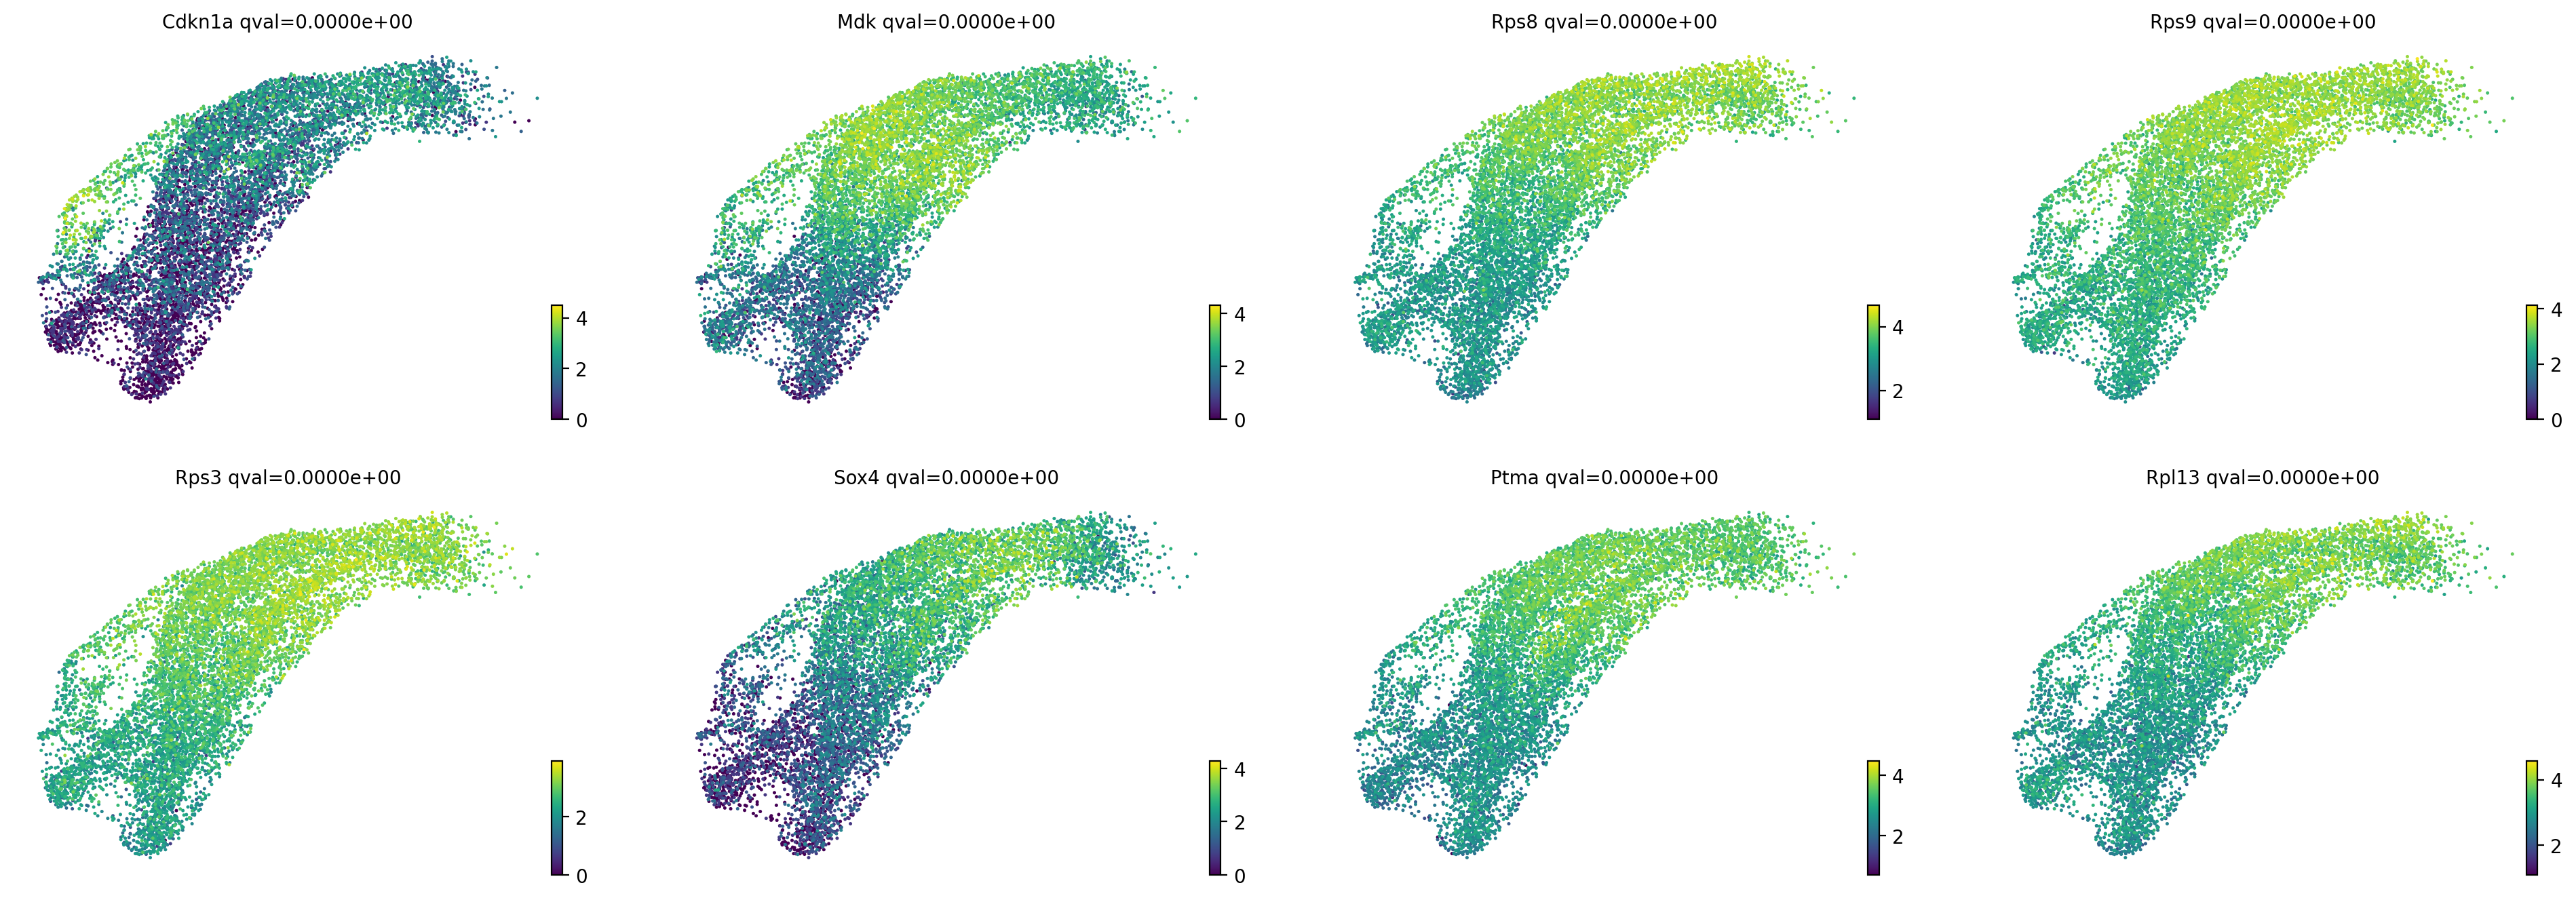

In [44]:
g.plot_lineage_drivers(lineage='Eps/Delta progenitors', dpi=200, basis='UMAP')

In [3]:
dpt_obs=pd.read_pickle(f'{Path}/dpt_epithelial.pkl')

In [8]:
dpt_obs=pd.read_pickle(f'{Path}/dpt_epithelial.pkl')
adata.obs['latent_time']=dpt_obs['dpt_pseudotime']

In [9]:
sns.set_style('darkgrid')

In [10]:
model = cr.models.GAM(adata)

In [ ]:
cr.pl.heatmap

  0%|          | 0/6 [00:00<?, ?gene/s]

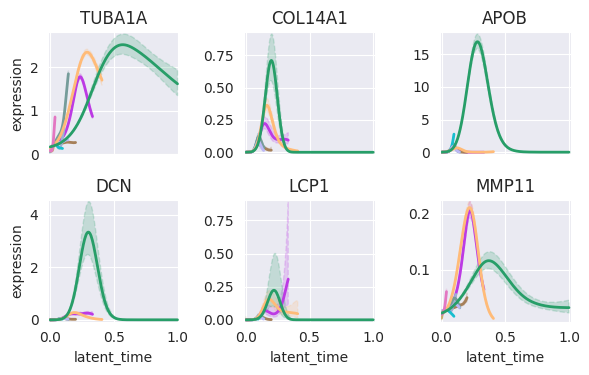

In [31]:
cr.pl.gene_trends(adata, model=model, genes=df.sort_values('basal cells_pval').head(6).index, ncols=3, 
                  hide_cells=True, figsize=(6, 4), same_plot=True, legend_loc=None)

In [ ]:
cr.pl.gene_trends(adata, model=model, genes=df.sort_values('basal cells_pval').head(1).index, ncols=3, 
                  hide_cells=True, figsize=(6, 4), same_plot=True)

In [29]:
drivers = g.compute_lineage_drivers(lineages="basal cells")

AttributeError: 'GPCCA' object has no attribute '_absorption_probabilities'

In [ ]:
cr.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="basal cells",
    cluster_key="level_2",
    show_fate_probabilities=True,
    genes=drivers.head(20).index,
    time_key="latent_time",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3)
)

In [18]:
df.sort_values('basal cells_pval')

colonocytes_2_corr  colonocytes_2_pval  colonocytes_2_qval  \
TUBA1A              -0.240142        0.000000e+00        0.000000e+00   
COL14A1             -0.084184       2.961072e-185       1.899208e-184   
APOB                -0.085129       2.062164e-189       1.337352e-188   
DCN                 -0.085220       8.112731e-190       5.280815e-189   
LCP1                -0.085513       4.097747e-191       2.677297e-190   
...                       ...                 ...                 ...   
OR13G1                    NaN                 NaN                 NaN   
DBX1                      NaN                 NaN                 NaN   
LINC01317                 NaN                 NaN                 NaN   
FAM170B                   NaN                 NaN                 NaN   
LCE5A                     NaN                 NaN                 NaN   

           colonocytes_2_ci_low  colonocytes_2_ci_high  enterocytes_4_corr  \
TUBA1A                -0.245504              -0.234766           -0.390479   
COL14A1               -0.089838              -0.078524           -0.030646   
APOB                  -0.090782              -0.079470            0.281716   
DCN                   -0.090874              -0.079561           -0.053760   
LCP1                  -0.091166              -0.079854           -0.109860   
...                         ...                    ...                 ...   
OR13G1                      NaN                    NaN                 NaN   
DBX1                        NaN                    NaN                 NaN   
LINC01317                   NaN                    NaN                 NaN   
FAM170B                     NaN                    NaN                 NaN   
LCE5A                       NaN                    NaN                 NaN   

           enterocytes_4_pval  enterocytes_4_qval  enterocytes_4_ci_low  \
TUBA1A           0.000000e+00        0.000000e+00             -0.395297   
COL14A1          5.332229e-26        1.058587e-25             -0.036337   
APOB             0.000000e+00        0.000000e+00              0.276462   
DCN              1.679761e-76        4.232031e-76             -0.059440   
LCP1             0.000000e+00        0.000000e+00             -0.115485   
...                       ...                 ...                   ...   
OR13G1                    NaN                 NaN                   NaN   
DBX1                      NaN                 NaN                   NaN   
LINC01317                 NaN                 NaN                   NaN   
FAM170B                   NaN                 NaN                   NaN   
LCE5A                     NaN                 NaN                   NaN   

           enterocytes_4_ci_high  ...  enteroendocrine cells_corr  \
TUBA1A                 -0.385639  ...                    0.295759   
COL14A1                -0.024953  ...                    0.031624   
APOB                    0.286953  ...                   -0.040725   
DCN                    -0.048077  ...                   -0.007944   
LCP1                   -0.104228  ...                   -0.012649   
...                          ...  ...                         ...   
OR13G1                       NaN  ...                         NaN   
DBX1                         NaN  ...                         NaN   
LINC01317                    NaN  ...                         NaN   
FAM170B                      NaN  ...                         NaN   
LCE5A                        NaN  ...                         NaN   

           enteroendocrine cells_pval  enteroendocrine cells_qval  \
TUBA1A                   0.000000e+00                0.000000e+00   
COL14A1                  1.400103e-27                4.085966e-27   
APOB                     1.225833e-44                4.425638e-44   
DCN                      6.281937e-03                1.000880e-02   
LCP1                     1.352939e-05                2.512192e-05   
...                               ...                

In [20]:
# compute putative drivers for the Beta trajectory
beta_drivers = g.compute_lineage_drivers(lineages="Beta")

# plot heatmap
cr.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages="basal cells",
    cluster_key="level_2",
    show_fate_probabilities=True,
    data_key="magic_imputed_data",
    genes=df.sort_values('basal cells_pval').head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

AttributeError: 'GPCCA' object has no attribute '_absorption_probabilities'

In [12]:
adata.var

Empty DataFrame
Columns: []
Index: [PYY, CHGA, GUCA2B, GUCA2A, GCG, SST, CCL4, REG4, CHGB, CCL21, NTS, CCL4L2, NPW, REN, GNRH2, FABP6, AHSP, MLN, CCL19, CRYBA2, TPSAB1, CCL3, LYZ, HLA-DRA, APOA4, PENK, TPH1, S100A8, APOC3, INSL5, TPSB2, NEK9, CA7, SPP1, GAL, CCL5, LCN15, CD74, CXCL8, S100A9, CXCL13, CLCA1, ACTG2, VIP, LTB, PCSK1N, CXCL10, HLA-DPA1, GNLY, GHRL, IL1B, TAC1, HLA-DRB1, STMN2, FCGBP, C1QA, CRYAB, NPY, CCK, NKG7, TAGLN, DEFA5, TTR, PPY, FABP4, APOA1, RNASE1, DEFA6, MPO, SPINK4, IGLL1, GRP, TFF3, CLPS, CD69, CPA3, CXCL14, DES, MUC2, SRGN, XCL2, AFP, PLA2G2A, PRTN3, ACTC1, CRABP1, IL7R, IFNG, CCL20, S100B, HSPA6, CLC, RBP2, CA4, C2CD4B, KLRB1, PRPH, ADAMDEC1, TYW5, RGS1, ...]

[1807 rows x 0 columns]

  0%|          | 0/1 [00:00<?, ?gene/s]

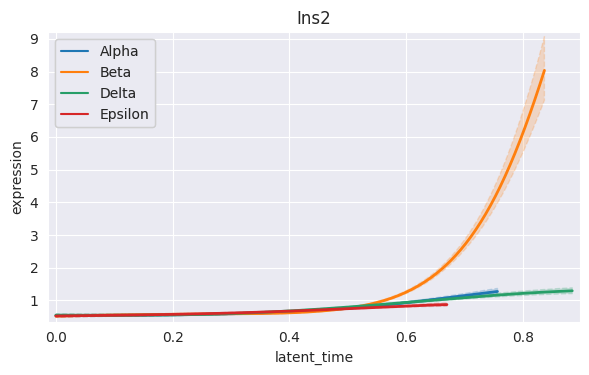

In [57]:
cr.pl.gene_trends(adata, model=model, genes=['Ins2'], ncols=3, hide_cells=True, figsize=(6, 4), same_plot=True)

  0%|          | 0/1 [00:00<?, ?gene/s]

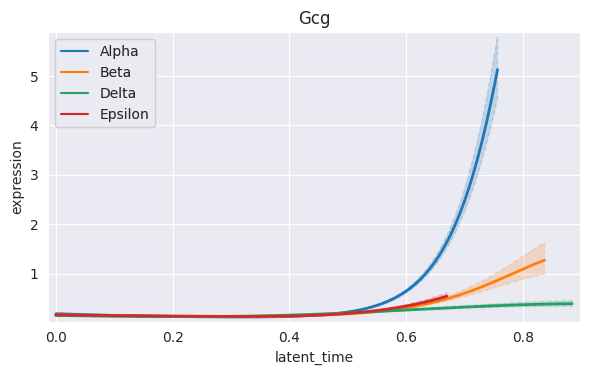

In [58]:
cr.pl.gene_trends(adata, model=model, genes=['Gcg'], ncols=3, hide_cells=True, figsize=(6, 4), same_plot=True)

  0%|          | 0/1 [00:00<?, ?gene/s]

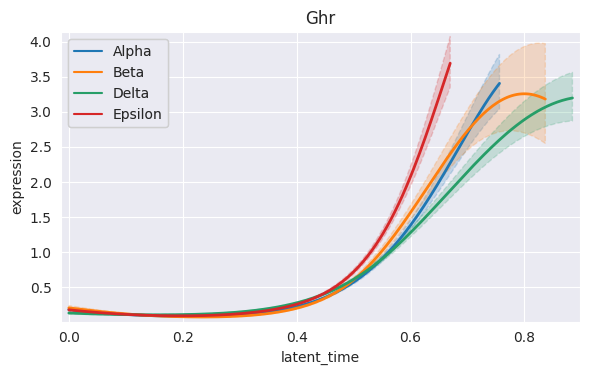

In [59]:
cr.pl.gene_trends(adata, model=model, genes=['Ghr'], ncols=3, hide_cells=True, figsize=(6, 4), same_plot=True)

  0%|          | 0/1 [00:00<?, ?gene/s]

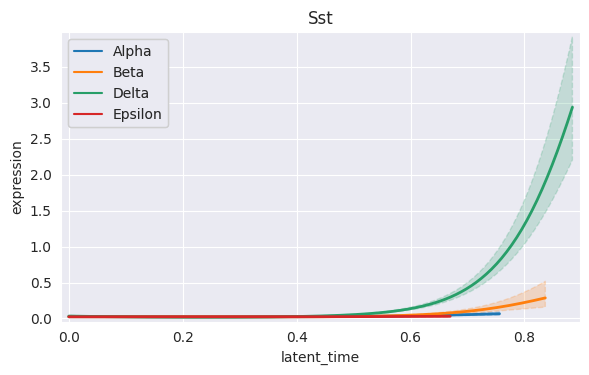

In [60]:
cr.pl.gene_trends(adata, model=model, genes=['Sst'], ncols=3, hide_cells=True, figsize=(6, 4), same_plot=True)

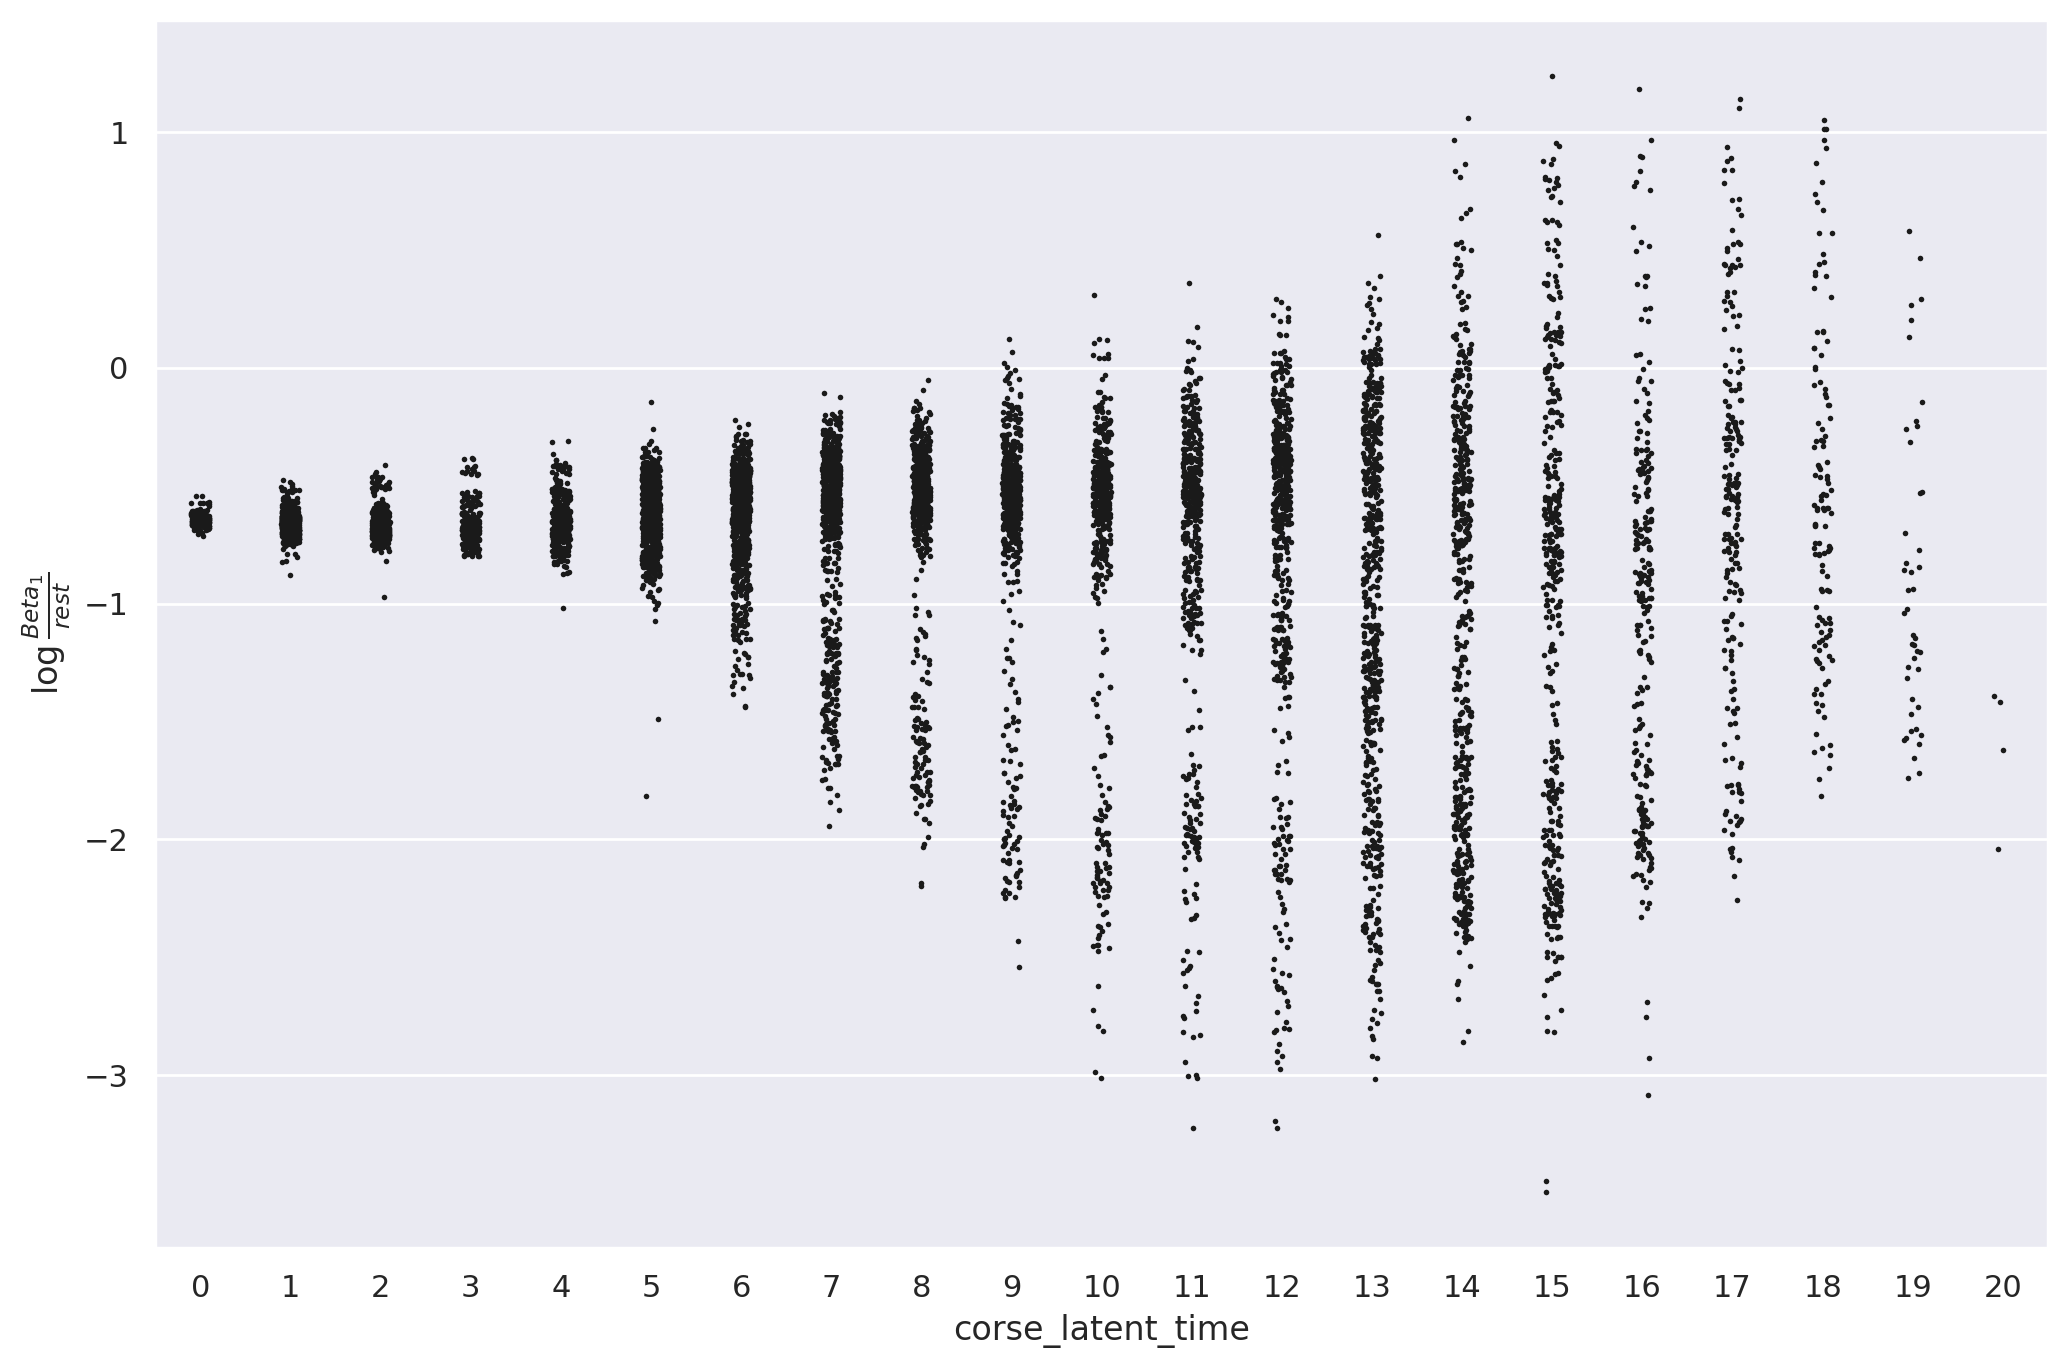

In [169]:
cr.pl.log_odds(adata, 'Beta_1',  time_key='corse_latent_time')

  0%|          | 0/4 [00:00<?, ?gene/s]

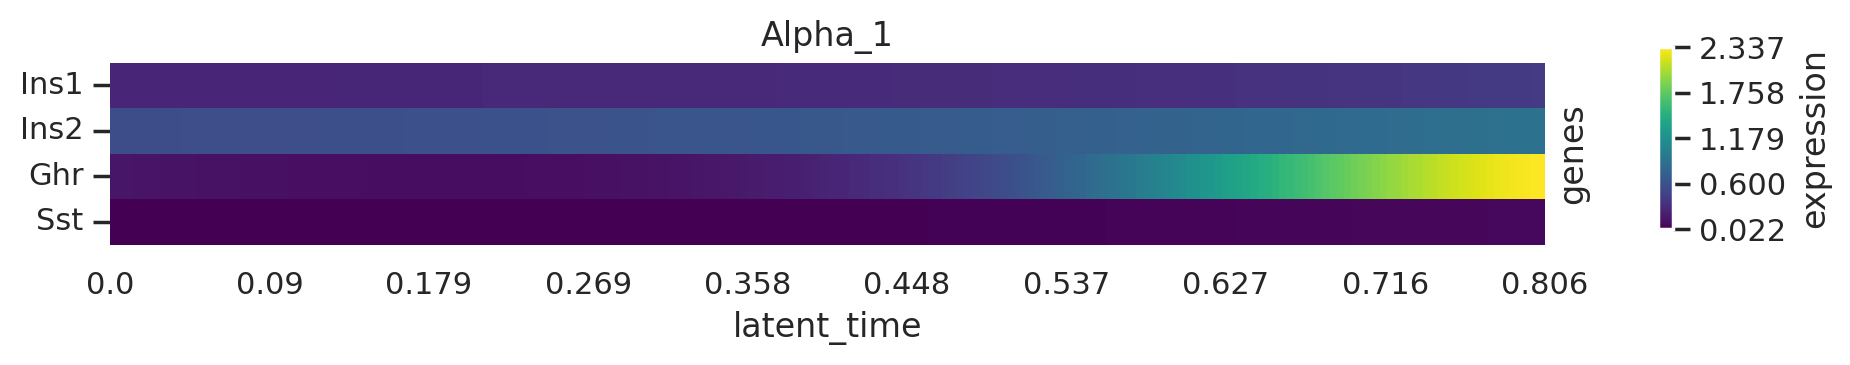

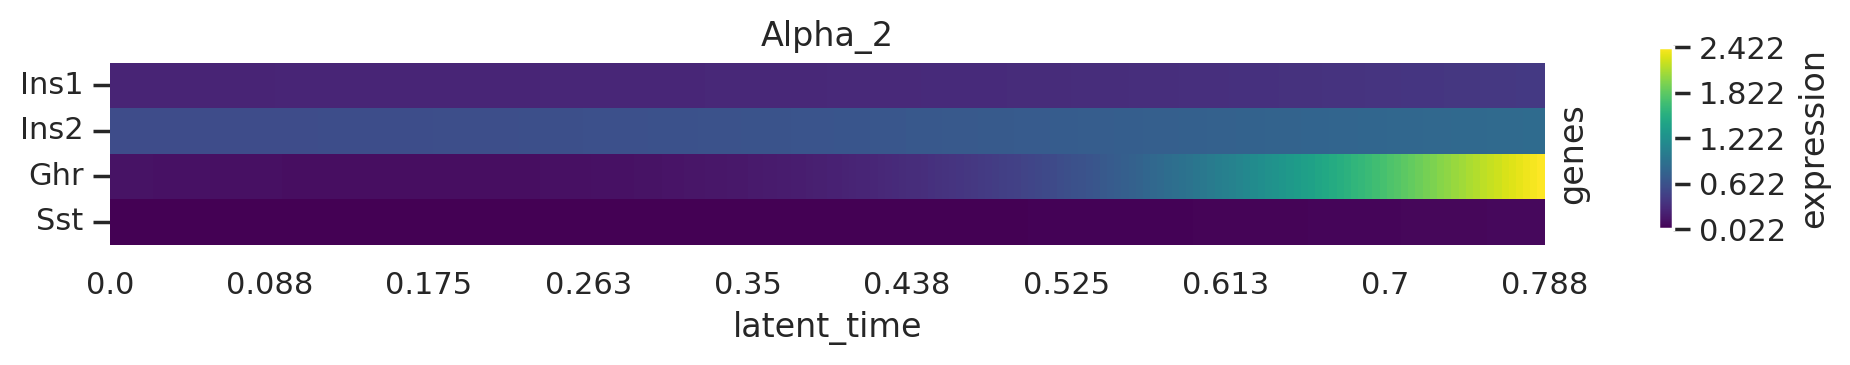

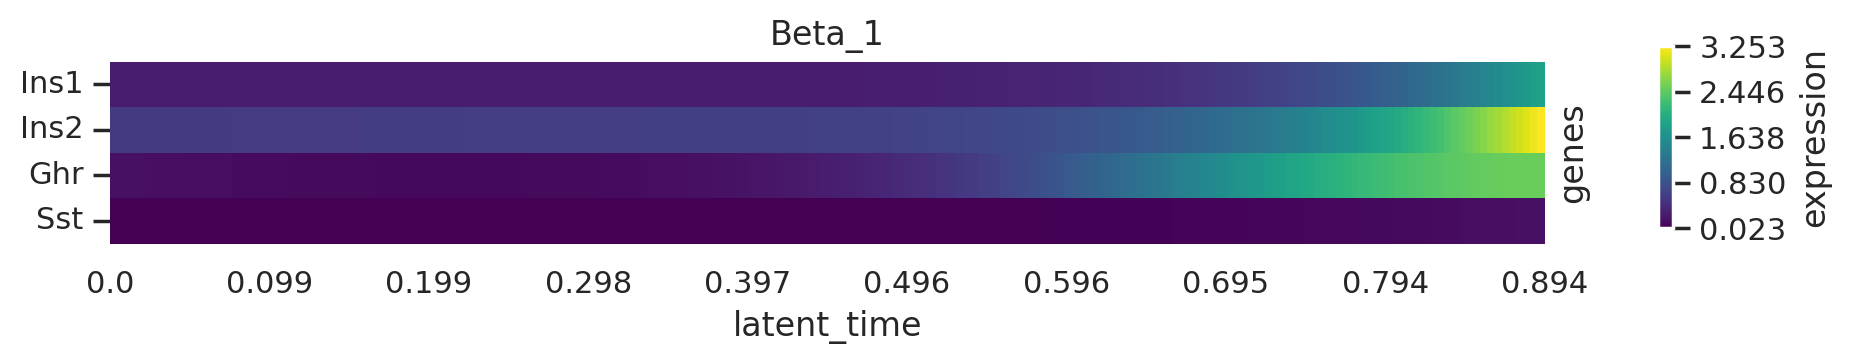

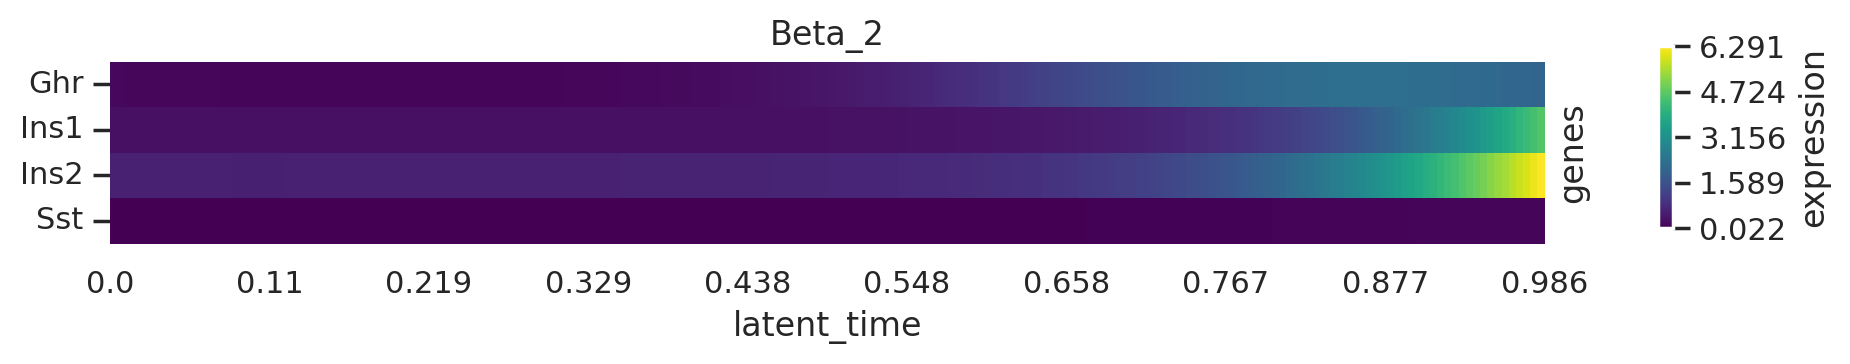

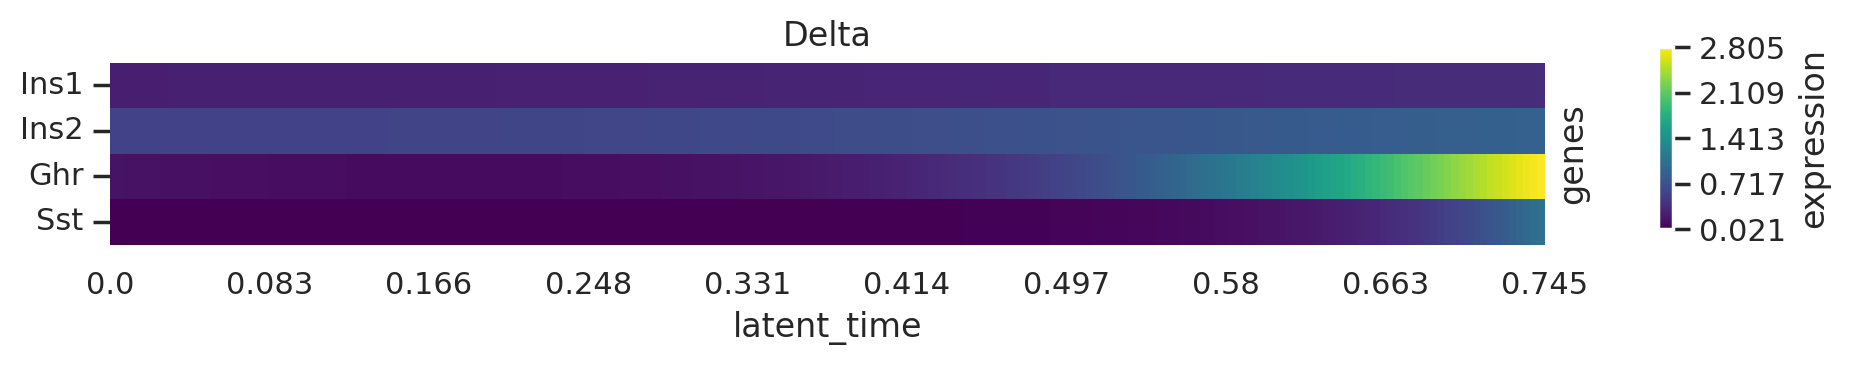

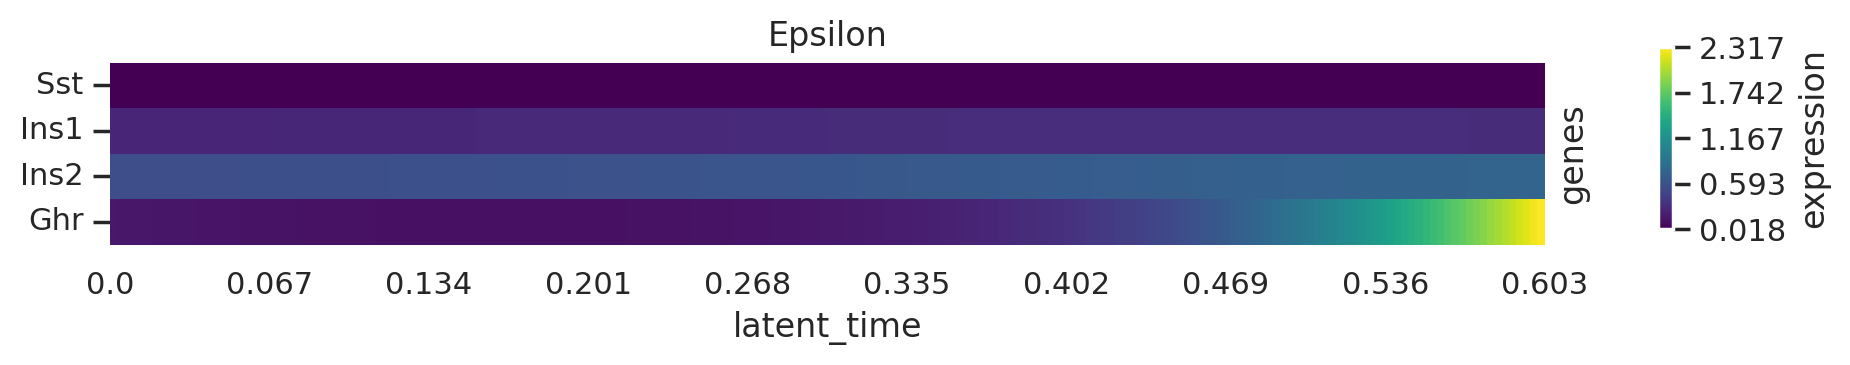

In [173]:
cr.pl.heatmap(adata, model, genes=['Ins1', 'Ins2', 'Ghr', 'Sst'], scale=False)

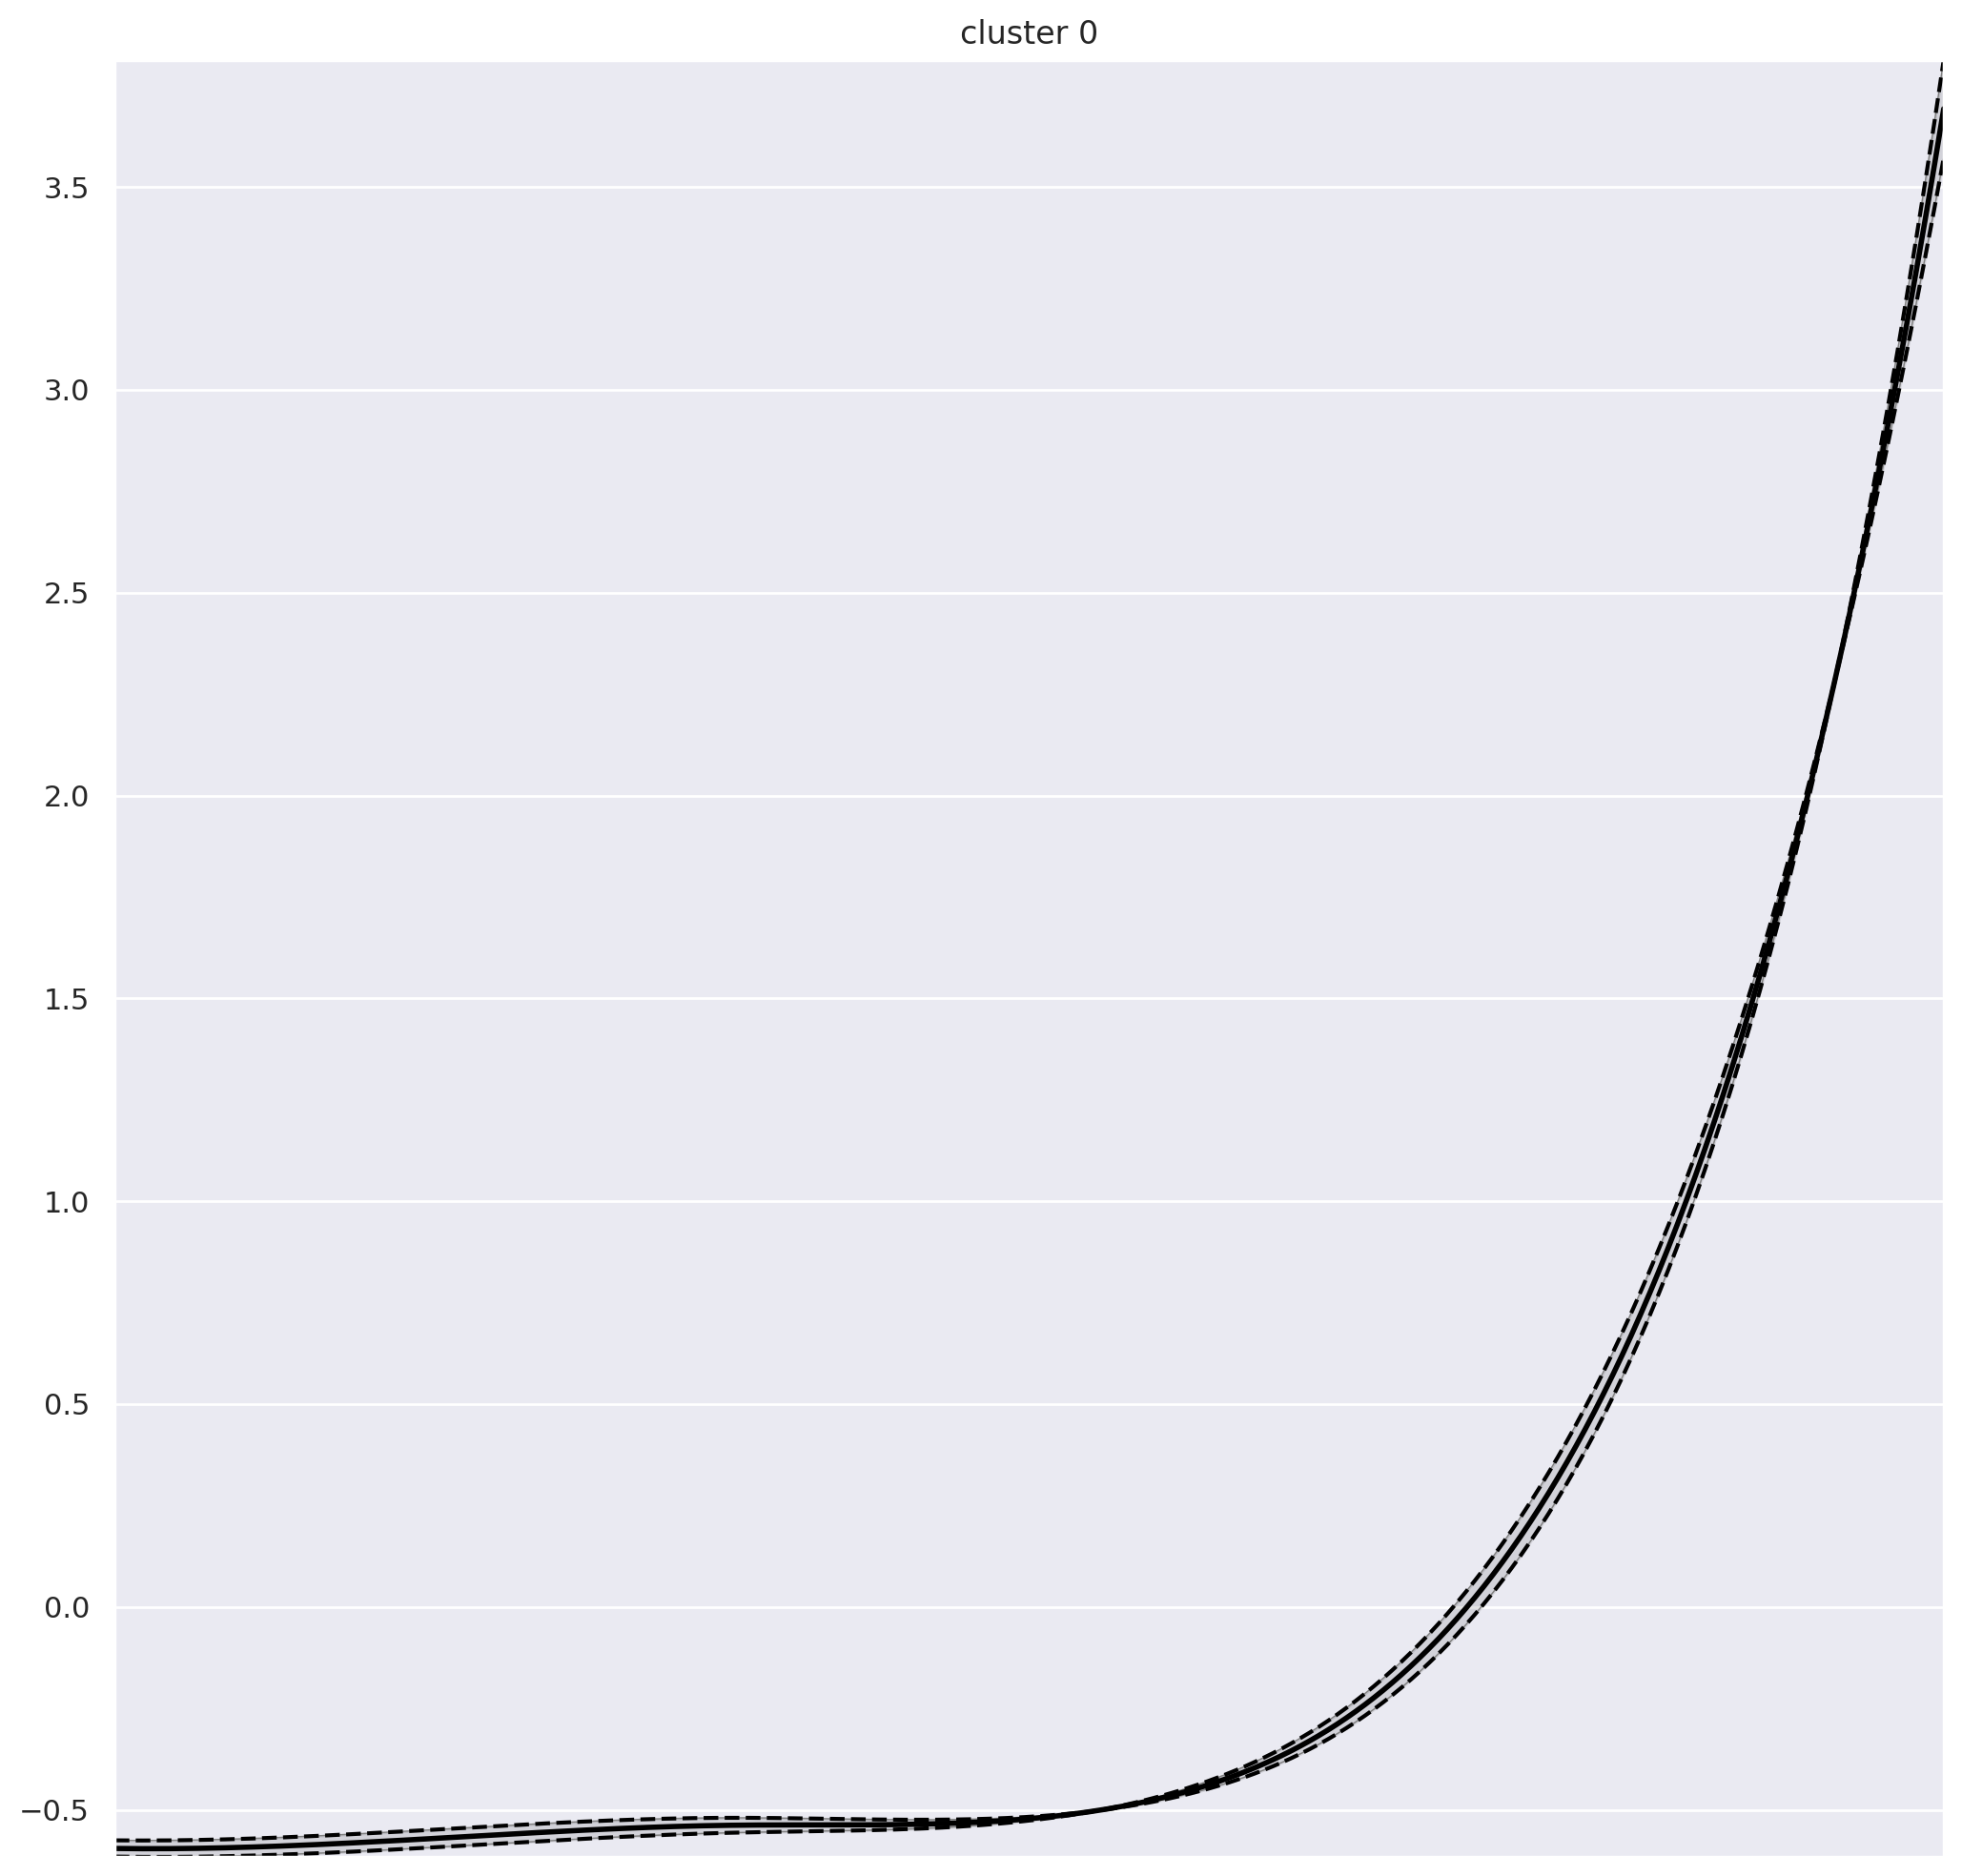

In [180]:
cr.pl.cluster_trends(adata, model, genes=['Ins1', 'Ins2', 'Ghr', 'Sst', 'Gcg'], lineage='Beta_1')

  0%|          | 0/5 [00:00<?, ?gene/s]

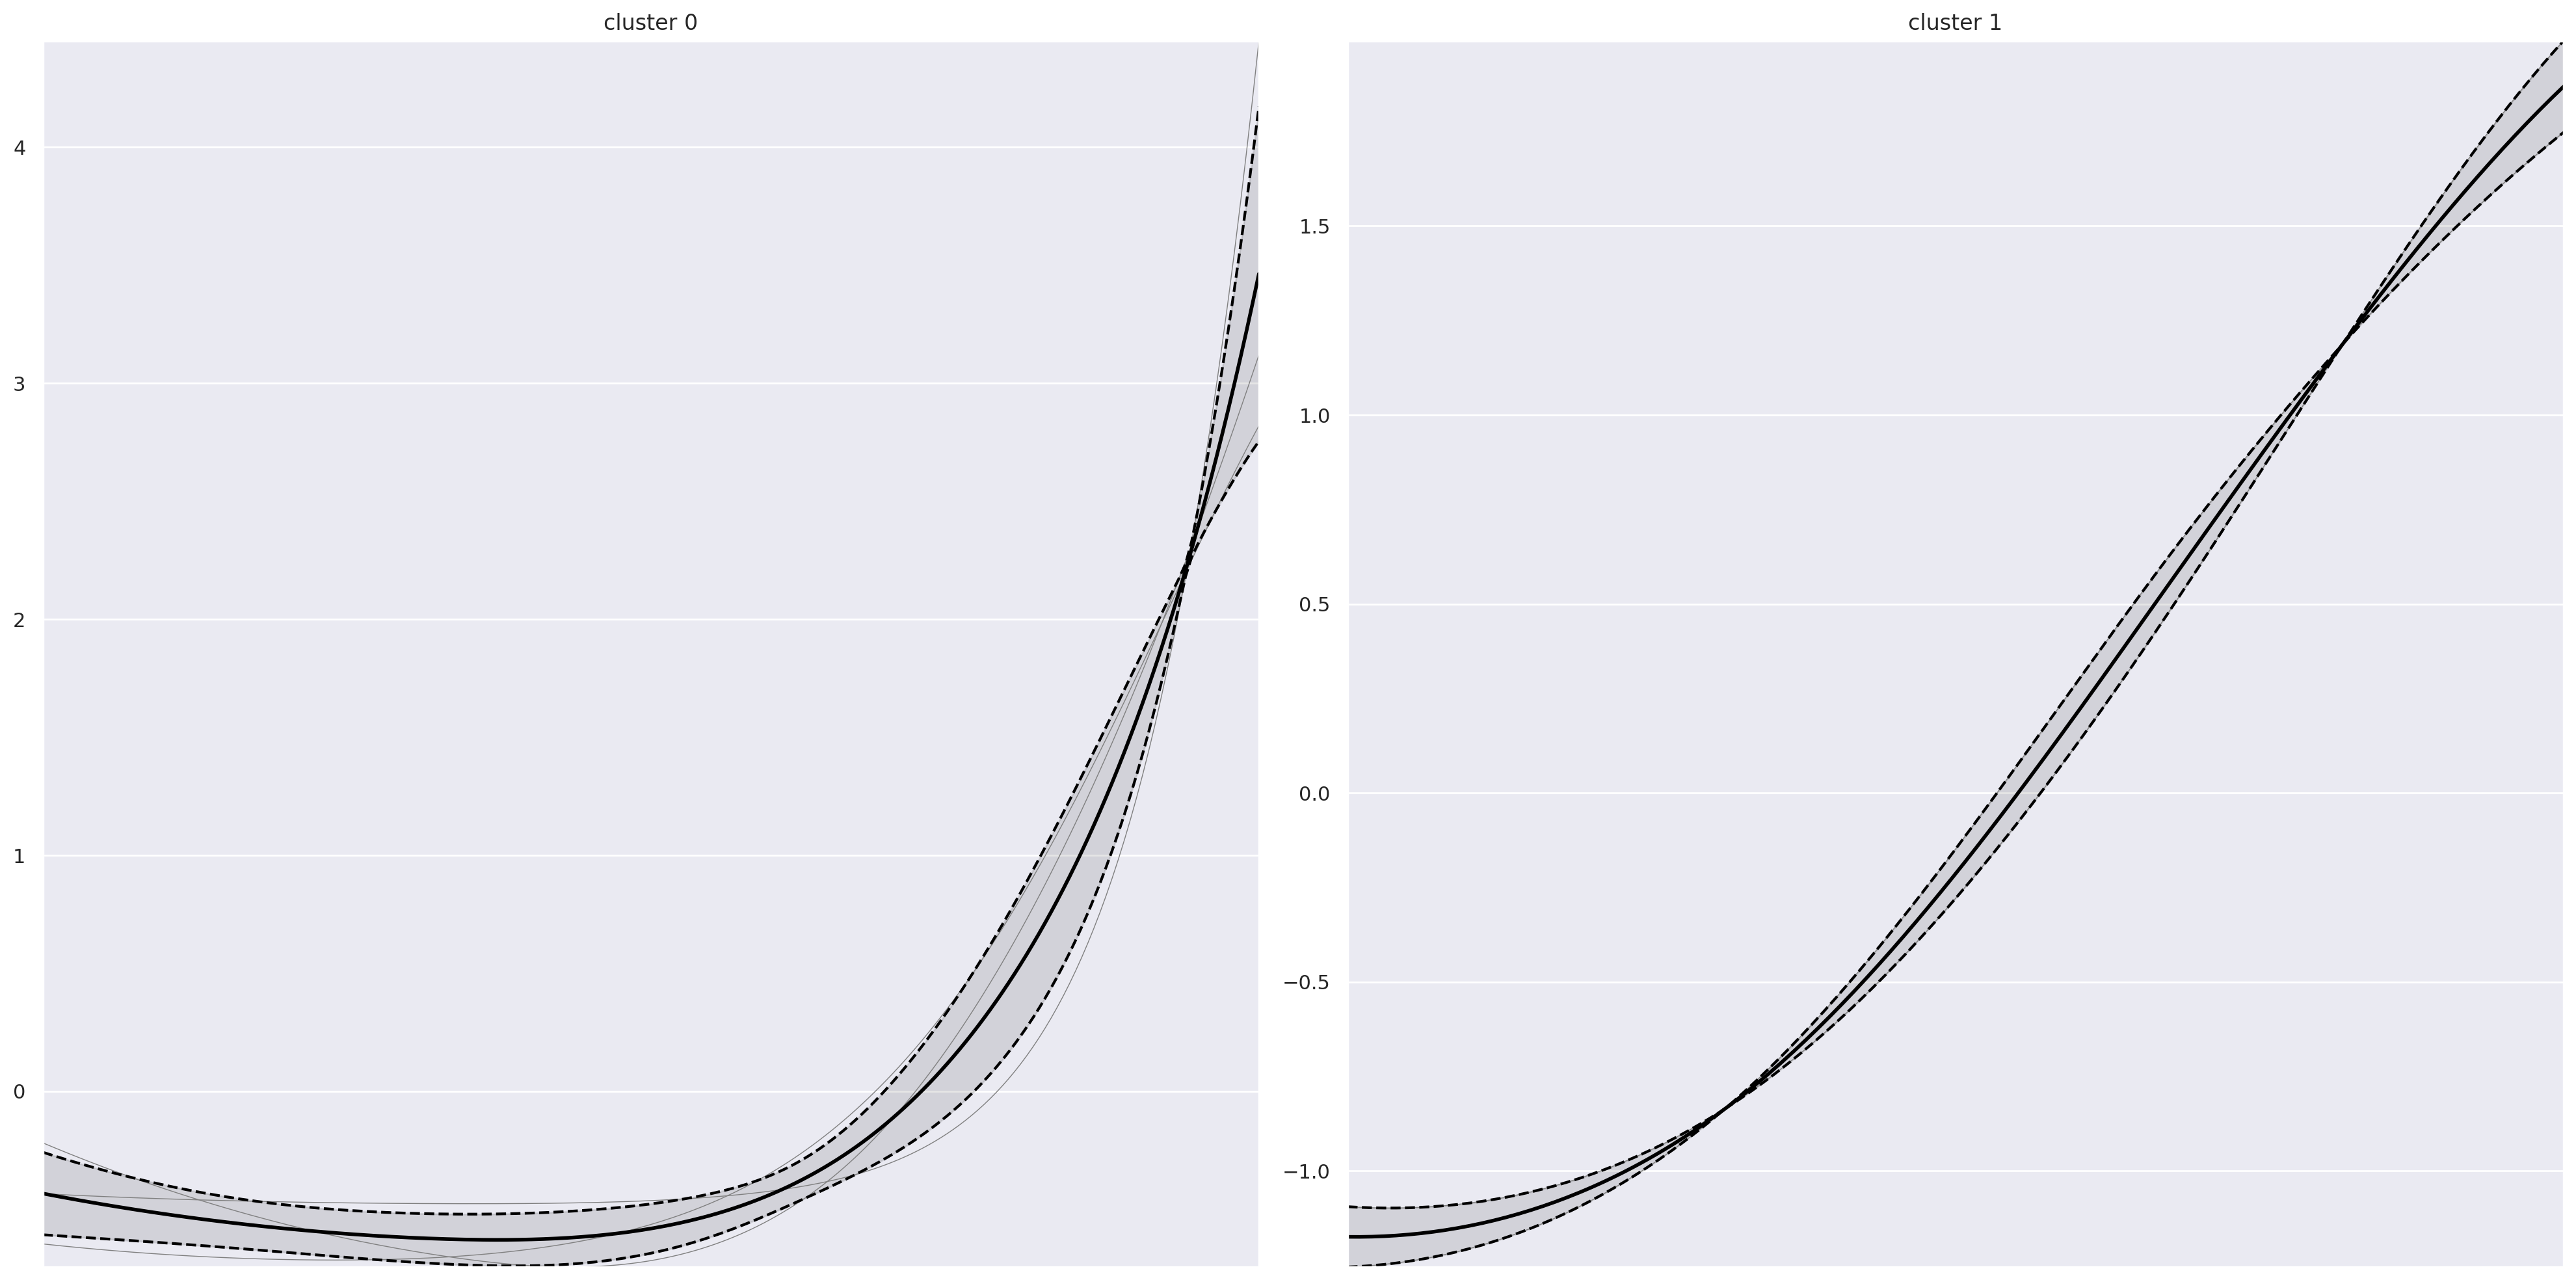

In [181]:
cr.pl.cluster_trends(adata, model, genes=['Ins1', 'Ins2', 'Ghr', 'Sst', 'Gcg'], lineage='Delta')

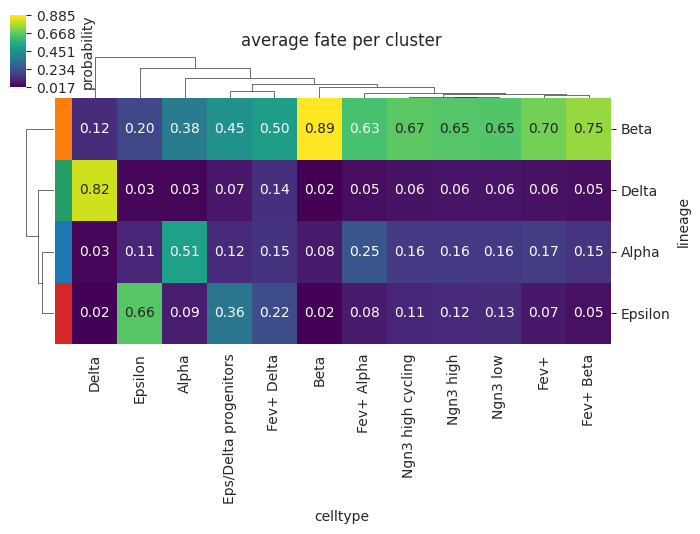

In [61]:
cr.pl.aggregate_absorption_probabilities(adata, mode='clustermap', cluster_key='celltype')

In [63]:
from cellrank._utils import Lineage
probs = Lineage.from_adata(adata)

In [65]:
term_cells=['Alpha', 'Beta', 'Delta', 'Epsilon']

In [66]:
# This reconstructs CellRanks absorption matrix
celltypes=list(set(adata.obs['celltype']))

from cellrank._utils import Lineage

l=[]
for ct in celltypes:
    inds=np.where(adata.obs['celltype']==ct)[0]
    
    probs_s=probs[inds]
    probabilities=np.array(probs[inds].sum(0).tolist())
    probabilities=probabilities/probabilities.sum()
    l.append((ct, probabilities))

In [67]:
columns=[a[0] for a in l]
data=[a[1][0] for a in l]

In [68]:
df=pd.DataFrame(data=data, index=columns, columns=term_cells).T

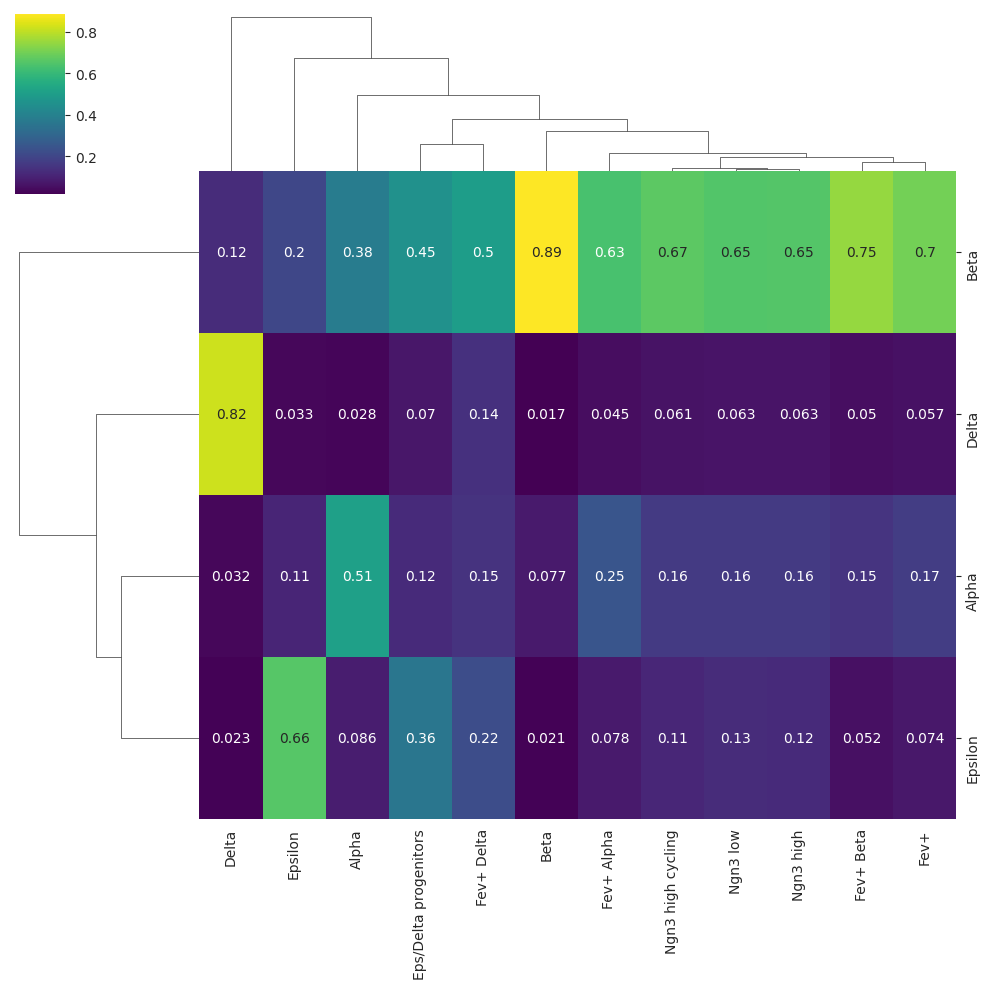

In [69]:
sns.clustermap(data=df, annot=True, cmap='viridis')

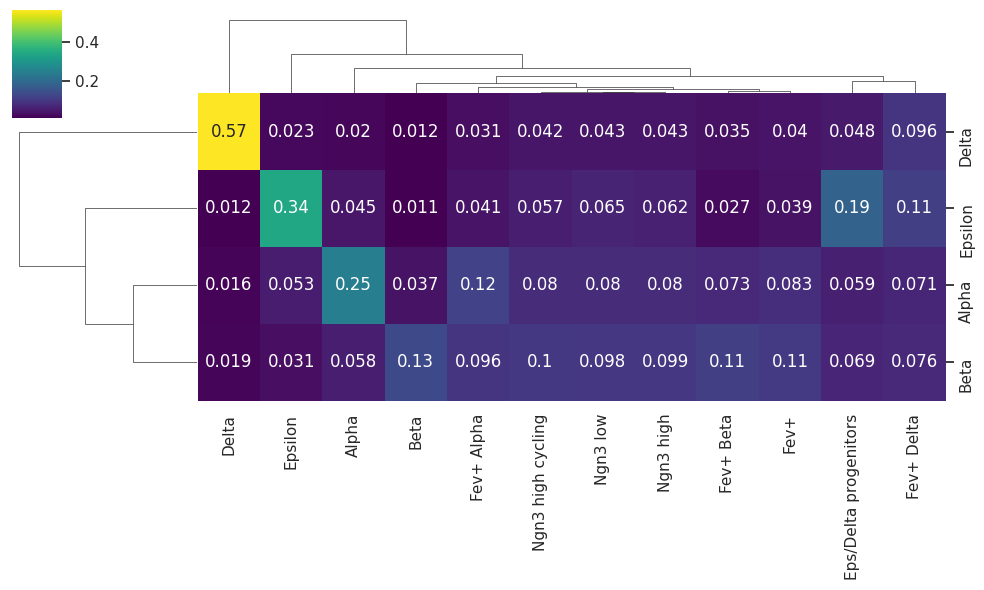

In [78]:
sns.set(rc={'figure.figsize':(12,1)})
sns.clustermap(data=df/df.sum(1)[:,None], annot=True, cmap='viridis', figsize=(10,6))

In [88]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

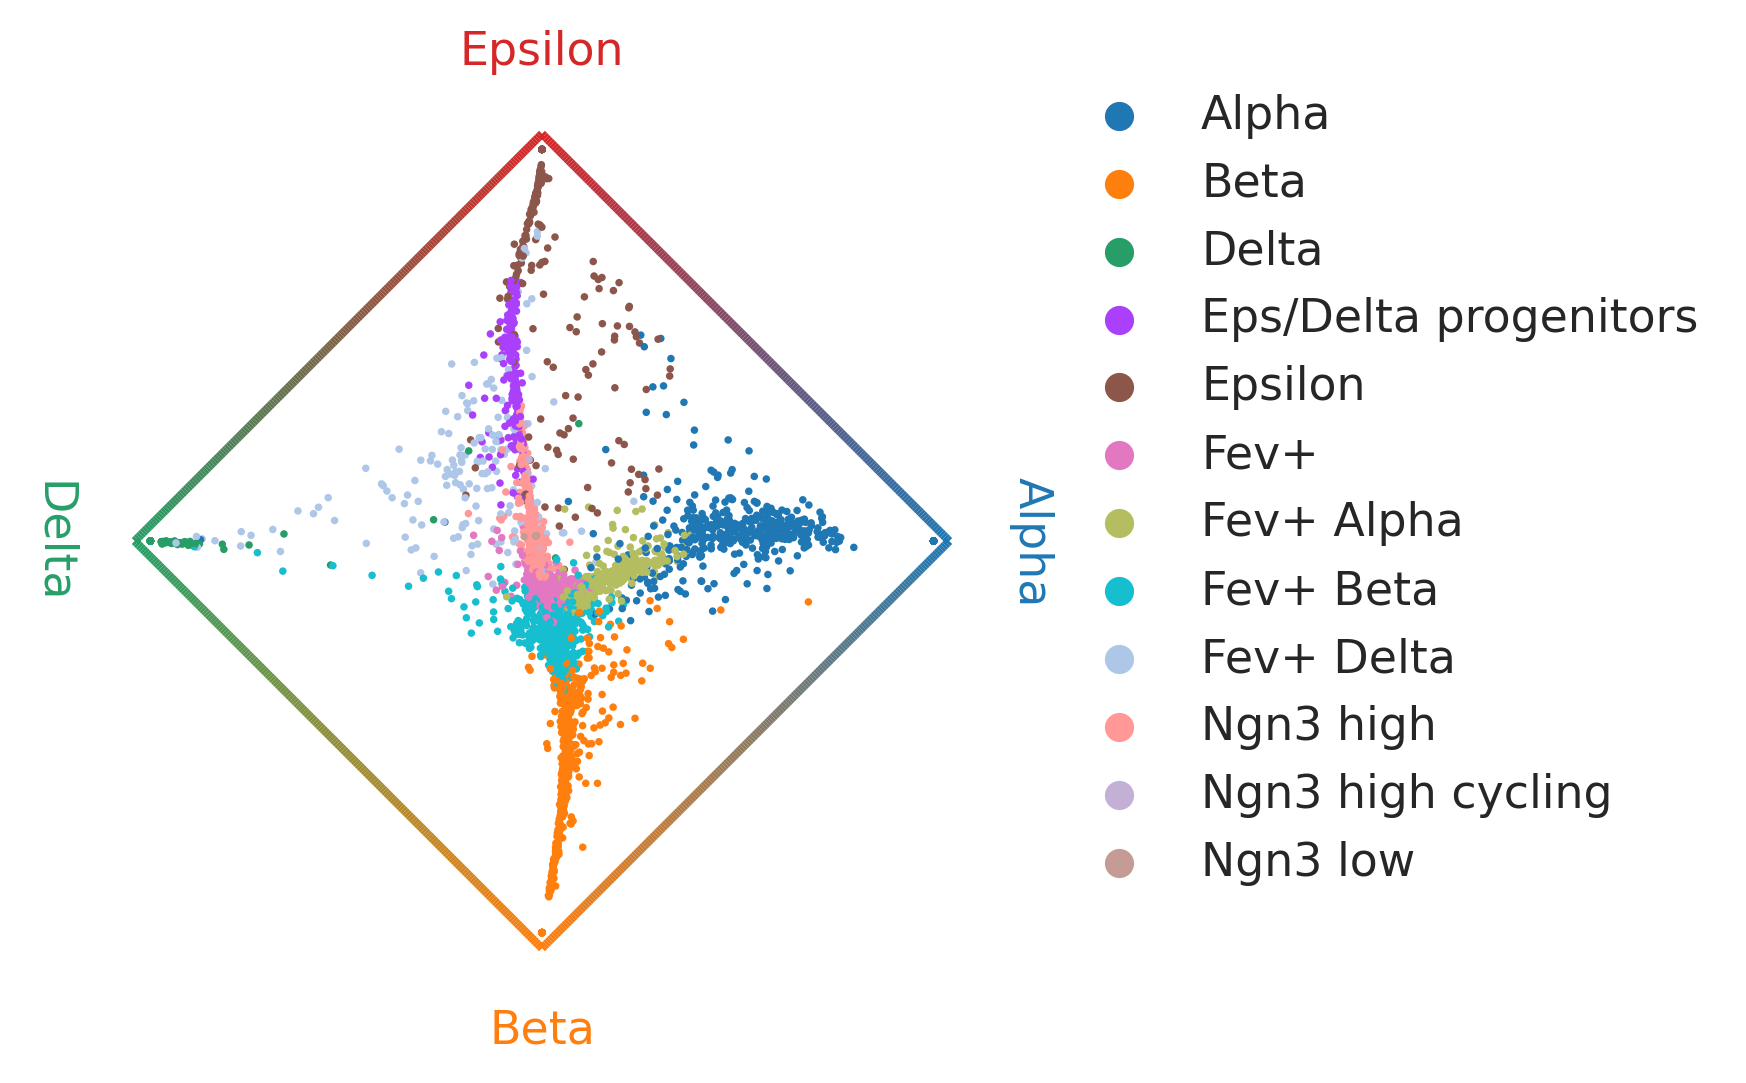

In [90]:
cr.pl.circular_projection(adata, keys=["celltype"], legend_loc="upper right", title='')